In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")


In [48]:
# read the csv file into a pandas data frame
jobs = pd.read_csv('indeed_jobs_data.csv')
# remove unnecessary first column
jobs.drop('Unnamed: 0', axis=1, inplace=True)

In [49]:
# take a look at the data set
jobs.head()

,company,job_title,location,salary,summary,est_salary
0,Accenture,Artificial Intelligence- Virtual Assistant & N...,Sydney NSW,"$110,000 - $150,000 a year",We have opportunities in both Sydney and Melbo...,80000
1,Black Cat Data,Junior Data Scientist,Sydney NSW,0,Relevant data professional certification. Abil...,80000
2,Rokt,Data Scientist - Analytics,Surry Hills NSW,0,Rokt is seeking a Data Scientist in Sydney to ...,80000
3,Allianz,DATA SCIENTIST,Melbourne VIC,0,As a skilled data scientist you will be workin...,80000
4,Freelancer.com,Data Scientist,Sydney NSW,"$65,000 - $110,000 a year",Proven experience as a data scientist or analy...,80000


In [50]:
# shape of the data
jobs.shape

(2373, 6)

In [51]:
# data types
jobs.dtypes

company       object
job_title     object
location      object
salary        object
summary       object
est_salary     int64
dtype: object

In [52]:
# checking for null values first
jobs.isnull().sum()

company       3
job_title     0
location      0
salary        0
summary       0
est_salary    0
dtype: int64

In [53]:
# there are 3 missing values for company columns, let check who are they
jobs[jobs.company.isnull()]

,company,job_title,location,salary,summary,est_salary
242,NaN,Semantic 3D Vision,Canberra ACT,"$85,000 - $93,000 a year",CSIRO staff are professional scientists with n...,80000
258,NaN,Head of Data Analysis,Brighton SA,0,Head of Data Analysis - Ongoing Position comme...,80000
260,NaN,Computer Vision for 3D,Canberra ACT,"$97,000 - $105,000 a year",Research Scientist - Computer Vision for 3D. Y...,80000


In [54]:
# the company names and job titles are mixed up in this case, just drop those 3 rows
jobs.drop(jobs.index[[242,258, 260]], inplace=True)

#### Average Salary

In [56]:
# take a look at different values of salary 
jobs.salary.value_counts()

0                             1791
$100,000 - $120,000 a year      18
$100,000 a year                 16
$900 a day                      14
$120,000 a year                 13
$90,000 - $120,000 a year       13
$120,000 - $140,000 a year      11
$150,000 a year                 10
$130,000 a year                 10
$95,275 - $115,276 a year        9
$600 a day                       9
$120,000 - $150,000 a year       9
$120,000 - $130,000 a year       8
$110,000 a year                  8
$80,000 - $100,000 a year        8
$110,000 - $120,000 a year       8
$120,000 - $160,000 a year       8
$82,574 - $93,689 a year         7
$80,000 - $90,000 a year         7
$800 a day                       6
$125,000 - $135,000 a year       6
$110,000 - $130,000 a year       6
$130,000 - $150,000 a year       6
$750 - $800 a day                6
$70,000 - $90,000 a year         5
$600 - $800 a day                5
$110,000 - $150,000 a year       5
$750 a day                       5
$100,000 - $130,000 

In [80]:
# generate new data set for easier work
jobs_df = jobs
salary = jobs.salary

In [58]:
# strip off the white space first, then the dollar values, a year, an hour and other confusing characters 
list_rep_char = ['$', ','] + [char for char in string.ascii_lowercase]
for rep_char in list_rep_char:
    salary = salary.apply(lambda x: x.replace(rep_char, ''))

# split based on the '-' character
salary = salary.apply(lambda x: x.split('-'))

# devide them into two columns
low = []
high = []
for record in salary:
    low.append(record[0])
    try:
        high.append(record[1])
    except:
        high.append(0)

In [59]:
# add low and high range columns into the dataframe
jobs_df['high'] = high
jobs_df.high = jobs_df.high.astype(float)
jobs_df['low'] = low 
jobs_df.low = jobs_df.low.astype(float)


In [60]:
# calculate average salary
jobs_df['avg_salary'] = (jobs_df.high + jobs_df.low) / 2


In [61]:
# if average salary is 0, then we will impute the indeed estimated salary
no_salary = jobs_df.avg_salary == 0
jobs_df.avg_salary[no_salary] = jobs_df.est_salary[no_salary]
# if average salary is under 150, that means it's hour wage
hour_salary = jobs_df.avg_salary < 150
jobs_df.avg_salary[hour_salary] = jobs_df.avg_salary[hour_salary] * 8 * 250 
# if average salary is over 150 but under 2000, that means it's day wage
day_salary = (jobs_df.avg_salary > 150) & (jobs_df.avg_salary < 2000)
jobs_df.avg_salary[day_salary] = jobs_df.avg_salary[day_salary] * 250 


#### Company

In [62]:
# Let investigate company names
jobs_df.company.value_counts().head(30)

Michael Page                       63
Bluefin Resources                  27
Talent International               27
Morgan McKinley                    26
Peoplebank                         24
Microsoft                          23
Victorian Government               23
Accenture                          22
CSIRO                              21
Hays                               21
IBM                                20
Hydrogen Group                     19
Hudson                             19
Evolution Recruitment Solutions    19
Macquarie Group Limited            18
Perigon Group                      16
EY                                 16
Deloitte                           15
Charterhouse                       15
Paxus                              14
Woolworths Supermarkets            14
Teradata                           14
Atlassian                          14
Ethos BeathChapman                 13
Cognizant                          12
Davidson                           12
Robert Half 

#### Location

In [63]:
# assign location to a new list
location = jobs_df.location.apply(lambda x: x.split())
# extract the last word - which is usually the state
state = [loc[len(loc)-1] for loc in location]

In [64]:
# take a look at what we get
set(state)

{'ACT',
 'Australia',
 'NSW',
 'NT',
 'QLD',
 'Queensland',
 'SA',
 'TAS',
 'Tasmania',
 'VIC',
 'Victoria',
 'WA',
 'Wales'}

In [65]:
# we can convert all of them to official abbreviatons, assume that 'Wales' is from 'New South Wales'
jobs_df['state'] = state

In [66]:
jobs_df.state = jobs_df.state.map({'ACT': 'ACT', 'Australia': 'NSW', 'NSW': 'NSW', 'NT':'NT',  'QLD': 'QLD',
                   'Queensland': 'QLD', 'SA':'SA', 'TAS':'TAS', 'Tasmania':'TAS', 'VIC': 'VIC',
                   'Victoria': 'VIC', 'WA':'WA', 'Wales': 'NSW'})

#### Job Title

In [67]:
# let take a look of job title frequency
jobs_df.job_title.value_counts()

Data Scientist                                                    98
Data Analyst                                                      57
Business Analyst                                                  47
Data Engineer                                                     21
Business Intelligence Analyst                                     18
Commercial Analyst                                                15
Senior Data Scientist                                             14
Data Scientist - Ecommerce                                        12
Senior Business Analyst                                           11
Senior Data Analyst                                               10
Test Analyst                                                       9
Financial Analyst                                                  8
Technical Business Analyst                                         8
Business Intelligence Developer                                    7
Data Scientist: (Big Data/ML) Amaz

In [68]:
# use tf-idf vectorizer to count the frequency of the word
job_title = jobs_df.job_title
title_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
title_fit = title_vec.fit(job_title)

In [69]:
# visualize count vectorizer
title_vec_df = pd.DataFrame(title_vec.fit_transform(job_title).todense(),
                            columns=title_fit.get_feature_names())
title_vec_df = title_vec_df.drop(['high', 'low', 'company'], axis=1)

In [70]:
# look at the most frequent features
title_features = title_vec.get_feature_names()
title_freq = title_vec.idf_
freq_table = pd.DataFrame({'Title Feature': title_features, 'Frequency': title_freq})
freq_table.sort_values('Frequency', ascending=False)

,Frequency,Title Feature
0,8.077920,056
2365,8.077920,manager regulatory
2337,8.077920,manager government
2338,8.077920,manager high
2339,8.077920,manager hris
2340,8.077920,manager human
2341,8.077920,manager industrial
2342,8.077920,manager industry
2343,8.077920,manager infrastructure
2344,8.077920,manager insurance


#### Summary

In [100]:
# use tf-idf vectorizer to count the frequency of the word
job_summary = jobs_df.summary
summary_vec = TfidfVectorizer(stop_words='english')
summary_fit = summary_vec.fit(job_summary)

In [95]:
# visualize count vectorizer
summary_vec_df = pd.DataFrame(summary_vec.fit_transform(job_summary).todense(),
                            columns=summary_fit.get_feature_names())
summary_vec_df = summary_vec_df.drop(['high', 'low', 'company'], axis=1)

In [73]:
# look at the most frequent features
summary_features = summary_vec.get_feature_names()
summary_freq = summary_vec.idf_
freq_table = pd.DataFrame({'Summary Feature': summary_features, 'Frequency': summary_freq})
freq_table.sort_values('Frequency', ascending=False)

,Frequency,Summary Feature
3836,8.077920,zoologists
1807,8.077920,inferences
1795,8.077920,index
1796,8.077920,indexed
1798,8.077920,indicators
1799,8.077920,indigenous
1802,8.077920,industrial
1806,8.077920,inecom
1811,8.077920,infobank
1828,8.077920,injury


#### Final Data

In [118]:
# We join all of those features together into our final data table
first_df = jobs_df.join(title_vec_df).dropna()
final_df = first_df.join(summary_vec_df, rsuffix='_summary')
# note that any features with _summary suffix are from summary vectorizer and to distinguish them from job_title vectorizer

### Quick EDA 

In [123]:
final_df.columns

Index(['company', 'job_title', 'location', 'salary', 'summary', 'est_salary',
       'high', 'low', 'avg_salary', 'state',
       ...
       'xva_summary', 'yawuru', 'year', 'years_summary', 'yield_summary',
       'yodlee', 'young', 'yrs', 'zealand', 'zoologists'],
      dtype='object', length=7895)

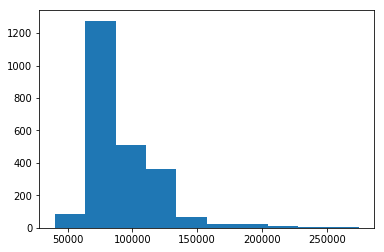

In [124]:
# Look at the distribution of jobs salary
plt.hist(final_df.avg_salary)
plt.show()

The distribution is extremely high skewed in this case. A log transform would handle the regression better.

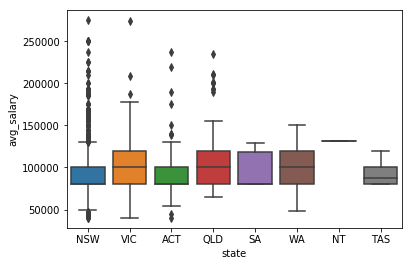

In [125]:
# Look at the jobs salary among state
sns.boxplot(x=final_df.state, y=final_df.avg_salary, data=final_df)
plt.show()

NSW has outstanding number of outliers in average salary, maybe because it's the most developed market for data related jobs. NT and SA don't have much data to display (just a few data points). ACT and TAS pay less than the average.

### Modelling: Jobs Salary Regression

Because we have way too many features, it can easily lead to overfitting if we use Linear Regression model. Therefore, regularization technique is needed in this case. Let's now do a grid search.

In [131]:
#prepare the dataset
regress_df = final_df.drop(['job_title', 'location', 'salary', 'summary', 'est_salary', 'high', 'low'], axis=1)
regress_df.shape

(2367, 7888)

In [132]:
# get dummies variables for company and state
regress_df = pd.get_dummies(regress_df)
regress_df.head()

,avg_salary,056,10,10 month,1000,11,11 contract,110,110 130k,12,...,company_tekFinder,company_u&u Recruitment Partners,state_ACT,state_NSW,state_NT,state_QLD,state_SA,state_TAS,state_VIC,state_WA
0,130000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,80000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2,80000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,80000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,87500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [133]:
# after get dummies we end up with 8727 features
# split the data
x_train, x_test, y_train, y_test = train_test_split(regress_df.drop('avg_salary', axis=1),
                                                    regress_df.avg_salary , test_size=0.25, random_state=42)

In [135]:
# Standardization
y_train = np.log(y_train)
y_test =  np.log(y_test)
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.fit_transform(x_test)

In [136]:
# Regression models with Elastic Net 
reg_model = ElasticNet()
reg_params = {
    'alpha': np.logspace(-5,0,1),
    'l1_ratio': np.arange(0.0, 1.0, 0.1)
}
reg_gridsearch = GridSearchCV(reg_model, reg_params, cv=10, 
                              scoring='neg_mean_squared_error', n_jobs=2)

In [366]:
# fit the model
reg_gridsearch.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'alpha': array([1.e-05]), 'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [370]:
# results
print('MSE:', -reg_gridsearch.best_score_)
print(reg_gridsearch.best_params_)
print(reg_gridsearch.best_estimator_)
reg_final_model = reg_gridsearch.best_estimator_

MSE: 0.058084084376482596
{'alpha': 1e-05, 'l1_ratio': 0.9}
ElasticNet(alpha=1e-05, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)


In [378]:
coef_table_1 = pd.DataFrame(dict(feature=regress_df.drop('avg_salary', axis=1).columns, coefficient=reg_final_model.coef_,
                                abs_coefficient=abs(reg_final_model.coef_)))
coef_table_1.sort_values(by='abs_coefficient', ascending=False).head(20)

,abs_coefficient,coefficient,feature
255,0.035973,0.035973,analyst industrials
5201,0.028912,-0.028912,dw_summary
1544,0.024719,0.024719,eo2
3450,0.024046,0.024046,senior research
8264,0.023836,0.023836,company_Hudson
1545,0.021886,0.021886,eo3
3808,0.021745,0.021745,technical project
244,0.021208,0.021208,analyst government
267,0.020909,0.020909,analyst major
4836,0.019928,0.019928,confirming


In [380]:
# Predict on the test set and get the score
y_predicted = reg_final_model.predict(x_test)

# Calculate MSE and R2
print('MSE:', metrics.mean_squared_error(y_test, y_predicted))
print('R2', metrics.r2_score(y_test, y_predicted))

MSE: 0.05354070945409158
R2 0.06774287701713444


We got a really poor model with only 6.67% R squared. However, we got a really low MSE, which is also a good sign. As we can see from the table, the most important coefficients are the keywords analyst industrials, dw_summary, senior_reasearch and company_Hudson

In [384]:
# Let try another ensemble model with the hope for better result - RandomForestRegressor seems to be the best in this case 

In [387]:
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [391]:
# Predict on the test set and get the score
y_predicted = reg.predict(x_test)

# Calculate MSE and R2
print('MSE:', metrics.mean_squared_error(y_test, y_predicted))
print('R2', metrics.r2_score(y_test, y_predicted))

MSE: 0.05511736636302601
R2 0.04028994169294742


The Random Forest Regression performance is worse than the previous model. We need to figure it out what is wrong with our model.

In [393]:
feature_table_1 = pd.DataFrame(dict(feature=regress_df.drop('avg_salary', axis=1).columns, 
                                    importance=reg.feature_importances_))
feature_table_1.sort_values(by='importance', ascending=False).head(20)

,feature,importance
8267,company_Hydrogen Group,0.390621
8264,company_Hudson,0.228172
255,analyst industrials,0.132228
1548,equities research,0.055647
5345,equities_summary,0.050795
8723,state_NSW,0.040733
8359,company_Michael Page,0.039288
8725,state_QLD,0.025307
5867,information_summary,0.012746
1238,developer,0.011584


### Modelling: Classification Data Scientist Job from other jobs

Let see if we can classify "Scientist" job from the other jobs

In [260]:
# now let exclude the tfidf vectorizer from job_title
classify_df = jobs_df.join(summary_vec_df, rsuffix='_summary')
classify_df.dropna(inplace=True)

In [261]:
# Label Data Scientist Job with 1 and Analyst and Engineer jobs with 0
def get_label(string):
    label = None
    if 'scientist' in string.lower():
        label = int(1)
    elif 'data analyst' in string.lower():
        label = int(0)
    elif 'engineer' in string.lower():
        label = int(0)
    else:
        label = np.nan    
    return(label)

In [262]:
# add jobs_category in our data
classify_df['jobs_category'] = classify_df.job_title.apply(get_label)

# look at the number of each class
print(classify_df.jobs_category.value_counts())

# now we should exclude job_title from our model to prevent spoling
classify_df.drop(['job_title', 'location', 'salary', 'summary', 'est_salary', 'high', 'low',
                  'including', 'looking', 'learning', 'using', 'work'], axis=1, inplace=True)

# drop missing value
classify_df.dropna(inplace=True)

# get dummy variables
classify_df = pd.get_dummies(classify_df)

0.0    364
1.0    266
Name: jobs_category, dtype: int64


In [263]:
# split the data -  note that this is the classification problem so we dont need to scale the data
x_train, x_test, y_train, y_test = train_test_split(classify_df.drop('jobs_category', axis=1),
                                                    classify_df.jobs_category , test_size=0.25, random_state=42)

In [264]:
# using Grid Search to pick the best Classifier
def best_random_forest(x_train, y_train, x_test, y_test):
    RF_params = {'n_estimators': [10,15],
            'max_features':[250,500],
            'min_samples_leaf':[1,5],
            'min_samples_split':[5,20]}
    RF_grid = GridSearchCV(RandomForestClassifier(), RF_params, cv=10)
    RF_grid.fit(x_train, y_train)
    rf_best = RF_grid.best_estimator_
    print(RF_grid.best_params_) 
    
    # models parameters
    print(rf_best)
    
    # calculate test values
    y_predicted = rf_best.predict(x_test)
    # Let's look at the confusion matrix, accuracy score and ROC AUC score
    print('Confusion matrix', metrics.confusion_matrix(y_test, y_predicted))
    print('Accuracy score', metrics.accuracy_score(y_test, y_predicted))
    print('Area under the curve', metrics.roc_auc_score(y_test, y_predicted))
    
    # look at those most importance features
    feature_table_2 = pd.DataFrame(dict(feature=x_train.columns, 
                                        importance=rf_best.feature_importances_))
    print(feature_table_2.sort_values(by='importance', ascending=False).head(20))

In [265]:
best_random_forest(x_train, y_train, x_test, y_test)

{'max_features': 500, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 15}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=500, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Confusion matrix [[72 21]
 [31 34]]
Accuracy score 0.6708860759493671
Area under the curve 0.6486352357320099
                                  feature  importance
3086                            scientist    0.119214
946                                  data    0.024463
3150                                 sets    0.020035
3087                           scientists    0.019504
3425                               sydney    0.017016
242                               analyst    0.016732
310